# Popularity Prediction
## Problem 1.1
As a preliminary step, we calculated the following statistics to get a holistic overview of the twitter dataset.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import os
import tqdm #python for loop progress bar

import datetime, time
import pytz



In [2]:
#these values were found via wc -l in CLI
hashtag_dict = {
    'gohawks':188136,
    'gopatriots':26232,
    'nfl':259024,
    'patriots':489713,
    'sb49':826951,
    'superbowl':1348767
}

In [3]:
data = {}
def load_data(filename=None, num_tweets=0):
    with open(filename, 'r') as file:
        df = pd.DataFrame(index=range(num_tweets),
                         columns=['date', 'total_tweets', 'total_retweets', 'sum_followers',
                                 'max_followers', 'total_replies', 'total_ranking',
                                 'total_impressions'])

#total_tweets, total_retweets, sum_followers, 
#max_followers, time_of_day, toatl_replies, total_ranking, total_impressions
        user_dict = {}
        for i, l in tqdm.tqdm(enumerate(file), total=num_tweets):
        
        #pandas df has first element as index and second as col
            tweet = json.loads(l)

            #get the date for sorting
            date = datetime.datetime.fromtimestamp(tweet['firstpost_date'])
            df.set_value(i, 'date', date)
            df.set_value(i, 'total_tweets', 1)
            df.set_value(i, 'total_retweets', tweet['metrics']['citations']['total'])

            #will sum and take max in post processing
            df.set_value(i, 'sum_followers', tweet['author']['followers'])
            df.set_value(i, 'max_followers', tweet['author']['followers'])
            df.set_value(i, 'total_replies', tweet['metrics']['citations']['replies'])
            df.set_value(i, 'total_ranking', tweet['metrics']['ranking_score'])
            df.set_value(i, 'total_impressions', tweet['metrics']['impressions'])
            
            user_id = tweet['tweet']['user']['id']
            user_dict[user_id] = tweet['author']['followers']
        return df, user_dict


   # print('#%s' % hashtag)
   # print('\tAvg # of tweets / hour = %.3f' % (total_tweets / total_hours))
   # print('\tAvg # of followers / user = %.3f' % (total_followers / total_users))
   # print('\tAvg # of retweets / tweet = %.3f' % (total_retweets / total_tweets))

In [4]:
def build_matrix(raw_df, index='date', mat_type='full', get_stats=False):
    """
    Iterates through the rows of the created dataframe and performs summing, maxes, and 
    creates time series
    """
    raw_df = raw_df.set_index(index)
    time_series = raw_df.groupby(pd.TimeGrouper(freq='60Min'))
    
    X = np.zeros((len(time_series), 8))
    y = np.zeros((len(time_series), 1))
    total_tweets = []
    total_retweets = []
    stats = None

    for i, (time_interval, g) in enumerate(time_series):
        """
        #get the date for sorting
        date = datetime.fromtimestamp(tweet_data['firstpost_date'])
        df.set_value(i, 'date', date)
        df.set_value(i, 'total_tweets', 1)
        df.set_value(i, 'total_retweets', tweet['metrics']['citations']['total'])
        
        #will sum and take max in post processing
        df.set_value(i, 'sum_followers', tweet['author']['followers'])
        df.set_value(i, 'max_followers', tweet['author']['followers'])
        df.set_value(i, 'total_replies', tweet['metrics']['citations']['replies'])
        df.set_value(i, 'total_ranking', tweet['metrics']['ranking_score'])
        df.set_value(i, 'total_impressions', tweet['metrics']['impressions'])


        """
        if(mat_type is 'full'):
            X[i, 0] = g.total_tweets.sum()
            X[i, 1] = g.total_retweets.sum()
            X[i, 2] = g.sum_followers.sum()
            X[i, 3] = g.max_followers.max()
            X[i, 4] = time_interval.hour     #store the hour of the day -> preserve order
            X[i, 5] = g.total_replies.sum()
            X[i, 6] = g.total_ranking.sum()
            X[i, 7] = g.total_impressions.sum()
        elif(mat_type is 'partial'):
            X[i, 0] = g.total_tweets.sum()
            X[i, 1] = g.total_retweets.sum()
            X[i, 2] = g.sum_followers.sum()
            X[i, 3] = g.max_followers.max()
            X[i, 4] = time_interval.hour     #store the hour of the day -> preserve order

        if get_stats:
            total_tweets.append(X[i,0])   #summed total tweets
            total_retweets.append(X[i,1]) #summed total retweets
            stats = (total_tweets, total_retweets)
        
    
        
        y[i, 0] = g.total_tweets.sum()
        
    return np.nan_to_num(X[:-1]), y[1:], stats

In [5]:
data = {}
user_dicts = []
for hashtag, num_tweets in hashtag_dict.items():
    print("---")
    print("Hashtag: ", hashtag, " with ntweets: ", num_tweets)
    print("---")
    data[hashtag], user_dict = load_data(filename=os.path.join('tweet_data','tweets_#' + hashtag +'.txt'), num_tweets=num_tweets)
    user_dicts.append(user_dict)

  0%|          | 775/188136 [00:00<00:24, 7743.73it/s]

---
Hashtag:  gohawks  with ntweets:  188136
---


  3%|▎         | 778/26232 [00:00<00:03, 7777.50it/s]

---
Hashtag:  gopatriots  with ntweets:  26232
---


  0%|          | 676/259024 [00:00<00:38, 6754.51it/s]

---
Hashtag:  nfl  with ntweets:  259024
---


  0%|          | 0/489713 [00:00<?, ?it/s]

---
Hashtag:  patriots  with ntweets:  489713
---


100%|██████████| 489713/489713 [00:54<00:00, 9042.87it/s]


---
Hashtag:  sb49  with ntweets:  826951
---


100%|██████████| 826951/826951 [01:22<00:00, 10044.36it/s]


---
Hashtag:  superbowl  with ntweets:  1348767
---


100%|██████████| 1348767/1348767 [03:56<00:00, 5697.97it/s]


In [6]:
frames = [data['gohawks'], 
          data['gopatriots'], 
          data['nfl'], 
          data['patriots'], 
          data['sb49'], 
          data['superbowl']]

frame_hashtags=['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']


all_data = pd.concat(frames)

In [7]:
i=0
plotting_data = [] #superbowl and nfl
for df in frames:
    X, y, stats = build_matrix(df, get_stats=True)
    total_tweets = stats[0]
    total_retweets = stats[1]
    user_dict = user_dicts[i]
    
    if(frame_hashtags[i] == 'superbowl' or frame_hashtags[i] == 'nfl'):     
        plotting_data.append(total_tweets)
        
    avg_followers = float(sum(user_dict.values()))/len(user_dict.keys())
    avg_tweets = np.mean(total_tweets)
    avg_retweets = np.mean(total_retweets)/avg_tweets
    print('#%s' % frame_hashtags[i])
    
    print('\tAvg # of tweets / hour = %.3f' % (avg_tweets))
    print('\tAvg # of followers / user = %.3f' % (avg_followers))
    print('\tAvg # of retweets / tweet = %.3f' % (avg_retweets))
    
    i+=1

#gohawks
	Avg # of tweets / hour = 193.357
	Avg # of followers / user = 1596.444
	Avg # of retweets / tweet = 2.015
#gopatriots
	Avg # of tweets / hour = 38.351
	Avg # of followers / user = 1292.203
	Avg # of retweets / tweet = 1.400
#nfl
	Avg # of tweets / hour = 279.422
	Avg # of followers / user = 4394.254
	Avg # of retweets / tweet = 1.539
#patriots
	Avg # of tweets / hour = 499.198
	Avg # of followers / user = 1607.441
	Avg # of retweets / tweet = 1.783
#sb49
	Avg # of tweets / hour = 1418.441
	Avg # of followers / user = 2229.695
	Avg # of retweets / tweet = 2.511
#superbowl
	Avg # of tweets / hour = 1399.136
	Avg # of followers / user = 3675.339
	Avg # of retweets / tweet = 2.388


In [8]:
#Verify that the dataframes are the right size
print(data['gohawks'].shape)
print(data['gopatriots'].shape)
print(data['nfl'].shape)
print(data['patriots'].shape)
print(data['sb49'].shape)
print(data['superbowl'].shape)

assert(data['gohawks'].shape[0] == hashtag_dict['gohawks'])
assert(data['gopatriots'].shape[0] == hashtag_dict['gopatriots'])
assert(data['nfl'].shape[0] == hashtag_dict['nfl'])
assert(data['patriots'].shape[0] == hashtag_dict['patriots'])
assert(data['sb49'].shape[0] == hashtag_dict['sb49'])
assert(data['superbowl'].shape[0] == hashtag_dict['superbowl'])


print(all_data.shape)
s=0
for hashtag, ntweets in hashtag_dict.items():
   s+=ntweets

print(s)

assert(all_data.shape[0] == s)


(188136, 8)
(26232, 8)
(259024, 8)
(489713, 8)
(826951, 8)
(1348767, 8)
(3138823, 8)
3138823


### a) Here, we show histograms with 1-hour bins that show the number the tweets in hour over time for two hashtag groups, #SuperBowl and #NFL. 

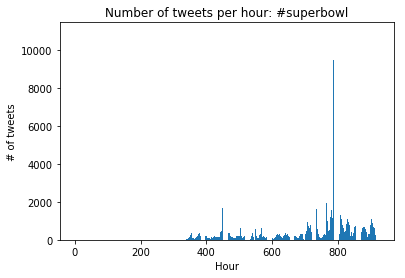

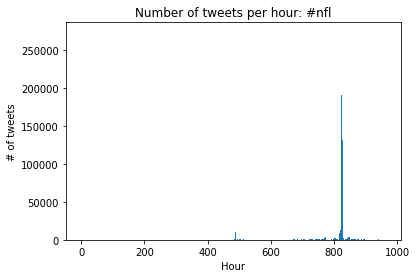

In [9]:

hashtags_to_plot = ['superbowl', 'nfl']
i=0
for hashtag in hashtags_to_plot:
    total_tweets = plotting_data[i]
    plt.xlabel('Hour')
    plt.ylabel('# of tweets')
    plt.title('Number of tweets per hour: #' + hashtag)
    
    x_range = range(len(total_tweets))
    plt.bar(x_range, total_tweets)
    plt.show()
    i+=1 
    


## Problem 1.2
For each hashtag, we first fitted a linear regression model using the following five features to
predict the number of tweets in the next hour, with features extracted from tweet data in
the previous hour.
The features we used are:
* Number of tweets (hashtag of interest)
* Total number of retweets (hashtag of interest)
* Sum of the number of followers of the users posting the hashtag
* Maximum number of followers of the users posting the hashtag
* Time of the day (which could take 24 values that represent hours of the day with respect to a given time zone)

For each model, we present the mean squared error and r2 score. Further, we analyzed the significance of each feature using the t-test and P-value, using a third-party statsmodels.api.

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime, time
import pytz
from itertools import compress
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

pst_tz = pytz.timezone('US/Pacific')

for df in frames:
    X, y, _ = build_matrix(df, mat_type='partial')
    lr = linear_model.LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    print("\t Mean squared error = %.3f" % (mean_squared_error(y, y_pred)))


    print(sm.OLS(y, X).fit().summary())

	 Mean squared error = 566824.371
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     191.6
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          7.78e-142
Time:                        18:11:32   Log-Likelihood:                -7818.7
No. Observations:                 972   AIC:                         1.565e+04
Df Residuals:                     967   BIC:                         1.567e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2

/Users/Jonny/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/Jonny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/Jonny/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Jonny/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Jonny/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


	 Mean squared error = 27345.569
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     263.3
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          3.58e-156
Time:                        18:11:33   Log-Likelihood:                -4458.0
No. Observations:                 683   AIC:                             8926.
Df Residuals:                     678   BIC:                             8949.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.91

	 Mean squared error = 42576118.849
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     703.7
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          1.04e-317
Time:                        18:11:38   Log-Likelihood:                -9824.9
No. Observations:                 963   AIC:                         1.966e+04
Df Residuals:                     958   BIC:                         1.968e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1

From observing the significance, or p-value, of each feature, it is evident that the total number of tweets for the current hour is not a statistically significant feature as the p-value is larger than 0.05 (assuming alpha at 0.05). Every other feature, however, shows a low p-value, indicating that it contributes greatly our final prediction, and are therefore are valuable features. In general, a low p-value is evidence for the change in the predictor's value to be directly correlated to the change in the response variable, which is what we desire.

Inutitively, this makes sense as the total tweets for the current hour would not affect the the total tweets for the next hour. Tweets do not become frequent when there is large number of tweets prior, instead, they become frequent when the previous tweets is associated with a large number of retweets and followers, signaling traction and actual social impact (at least virutally). 

## Problem 1.3
Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting accuracy and significance of variables.

The first features we attempted to add were total number of "favorites" per hour, total number of replies per hour, and total number of verified tweeters posting that hour. The motivation for looking at the number of verified tweeters was the hypothesis that a verified public figure would be able to influence the number of tweets having to do with a subject he or she tweeted about. Most verified accounts are celebrities. For example, it's likely that if Tom Brady tweeted "#gopatriots", there would be more retweets and comments sharing this hashtag due to the network effect. It turned out that in the dataset, not many users are verified and the p-value indicated that this feature was not important. The model with these features added did signficantly worse and exhibited an R2-value of 0.4.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime, time
import pytz
from itertools import compress
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

pst_tz = pytz.timezone('US/Pacific')

for df in frames:
    X, y,_ = build_matrix(df, mat_type='full')
    lr = linear_model.LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    print("\t Mean squared error = %.3f" % (mean_squared_error(y, y_pred)))
    print(sm.OLS(y, X).fit().summary())

	 Mean squared error = 556864.412
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     123.7
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          3.31e-142
Time:                        18:11:39   Log-Likelihood:                -7810.0
No. Observations:                 972   AIC:                         1.564e+04
Df Residuals:                     964   BIC:                         1.567e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.6

	 Mean squared error = 18516861.767
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     332.2
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          8.72e-210
Time:                        18:11:45   Log-Likelihood:                -5696.0
No. Observations:                 582   AIC:                         1.141e+04
Df Residuals:                     574   BIC:                         1.144e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            12

While we initially started with the following features:
- total number of favorites per hour
- total number of replies per hour
- total number of verified tweeters that hour

Favorites and verified tweets were ineffective features. There are very few verified accounts so it resulted in sparsity and not much information gain. The number of favorites was also pretty low. The total number of replies seemed to improve performance, so we left it in. The next test involved the following three features, after having removed favorites and verified tweeters:
- total number of replies per hour
- total ranking 
- total impressions

Ranking and impressions indicate the popularity or visibility of a tweet/tweeter, so these seemed like reasonable additions. These features improved RMSE performance by several points in terms of R2, and were vastly more effective than the previously added sparse features.


## Problem 1.4
In this part, we would like to perform 10-fold cross-validation on the models from the previous part and calculate the average prediction error over samples in the held-out part for the 10 tests. For this problem, you should split the feature data (your set of (features, predictant) pairs for windows) into 10 parts to perform cross-validation. Also, your evaluated error should be of the form |Npredicted − Nreal|.



In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error #RMSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

def cv(X, y, model, n_splits=10, verbose=True, display_last_ols=False):
    kf = KFold(n_splits=n_splits)
    rmses = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        #print(sm.OLS(y, X).fit().summary())
#        print(X_train.shape)
#        print(y_train.shape)
        if(model == 'lr'):
            lr = sm.OLS(y_train, X_train).fit()
            y_preds = lr.predict(X_test)
        elif(model == 'rf'):
            rf = RandomForestRegressor()
            rf.fit(X_train, y_train)
            y_preds = rf.predict(X_test)
        elif(model == 'mlp'):
            mlp = MLPRegressor()
            mlp.fit(X_train, y_train)
            y_preds = mlp.predict(X_test)
        
        rmses.append(mean_squared_error(y_test, y_preds))
        
        
    if verbose: 
        print("Errors from CV are: ", rmses)
        print("Averaged error is: ", np.mean(rmses))
        if model is 'lr':
            print(lr.summary())
        
    return rmses
    

In [14]:

#datetime args: Attributes: year, month, day, hour, minute, second, microsecond, and tzinfo.
#before Feb 1, 8:00am
first_date_marker = datetime.datetime(2015, 2, 1, 8, 0, 0, 0)

#end at 8pm
second_date_marker = datetime.datetime(2015, 2, 1, 20, 0, 0, 0)



In [15]:
def filter_and_test(df, model, verbose=True):
    ###Set up the data by filtering via index
    #Before Feb. 1, 8:00 a.m.
    #sort out the times in the dataframe before this period
    df_p1 = df[df.date < first_date_marker]


    #Between Feb. 1, 8:00 a.m. and 8:00 p.m. 
    df_p2 = df[(df.date > first_date_marker) &
               (df.date < second_date_marker)]

    #After Feb. 1, 8:00 p.m.
    df_p3 = df[df.date > second_date_marker]

    print("Before Feb. 1, 8:00 a.m.")
    X_df_p1, y_df_p1, _ = build_matrix(df_p1, index='date')
    errors_df_p1 = cv(X_df_p1, y_df_p1, model, verbose=verbose) #default splits = 10 no need to specify
   # print("Average cv error: ", np.mean(errors_df_p1))
    
    print("Between Feb. 1, 8:00 a.m. and 8:00 p.m.")
    X_df_p2, y_df_p2, _ = build_matrix(df_p2, index='date')
    errors_df_p2 = cv(X_df_p2, y_df_p2, model,verbose=verbose)
  #  print("Average cv error: ", np.mean(errors_df_p2))
    
    print("After Feb. 1, 8:00 p.m.")
    X_df_p3, y_df_p3, _ = build_matrix(df_p3, index='date')
    errors_df_p3 = cv(X_df_p3, y_df_p3, model,verbose=verbose)
   # print("Average cv error: ", np.mean(errors_df_p3))

    return np.mean(errors_df_p1), np.mean(errors_df_p2), np.mean(errors_df_p3)


### Per-Hashtag Performance with 3 Models
For each hashtag, report the average cross-validation errors for the 3 different models. Note that you should do the 90-10% splitting for each model within its specific time window. I.e. Only use data within one of the 3 periods above for training and testing each time, so for each period you will run 10 tests.

In [16]:
#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

In [17]:
%%time
import os
import tqdm

models = ['lr', 'rf', 'mlp']
results = {}
for model in models:
    print("Model is: "+model)
    i = 0
    p1_errs, p2_errs, p3_errs = [],[],[]
    for df in frames:
        err_p1, err_p2, err_p3 = filter_and_test(df, model, verbose=False)
        print("Hashtag: ", frame_hashtags[i])
        print("Period 1 avg. cv error: ", err_p1)
        print("Period 2 avg. cv error: ", err_p2)
        print("Period 3 avg. cv error: ", err_p3)
        p1_errs.append(err_p1)
        p2_errs.append(err_p2)
        p3_errs.append(err_p3)
        i+=1
    results[model] = [np.mean(p1_errs), np.mean(p2_errs), np.mean(p3_errs)]
            
#            full_errors = cv(X_full, y_full, n_splits=10)
 #           print("Errors from full set CV: ", full_errors)
  #          print("Mean error from CV: ", np.mean(full_errors))


Model is: lr
Before Feb. 1, 8:00 a.m.
Between Feb. 1, 8:00 a.m. and 8:00 p.m.
After Feb. 1, 8:00 p.m.
Hashtag:  gohawks
Period 1 avg. cv error:  1382106.04845
Period 2 avg. cv error:  5101080553.83
Period 3 avg. cv error:  340217.549689
Before Feb. 1, 8:00 a.m.
Between Feb. 1, 8:00 a.m. and 8:00 p.m.
After Feb. 1, 8:00 p.m.
Hashtag:  gopatriots
Period 1 avg. cv error:  2403.64668795
Period 2 avg. cv error:  75715827423.6
Period 3 avg. cv error:  80.8086140564
Before Feb. 1, 8:00 a.m.
Between Feb. 1, 8:00 a.m. and 8:00 p.m.
After Feb. 1, 8:00 p.m.
Hashtag:  nfl
Period 1 avg. cv error:  58859.8755465
Period 2 avg. cv error:  315472851.69
Period 3 avg. cv error:  25227.5050623
Before Feb. 1, 8:00 a.m.
Between Feb. 1, 8:00 a.m. and 8:00 p.m.
After Feb. 1, 8:00 p.m.
Hashtag:  patriots
Period 1 avg. cv error:  368516.190929
Period 2 avg. cv error:  9815441030.44
Period 3 avg. cv error:  51652.4952138
Before Feb. 1, 8:00 a.m.
Between Feb. 1, 8:00 a.m. and 8:00 p.m.
After Feb. 1, 8:00 p.m.
Has

In [18]:
sum_errors = []
for model, result_arr in results.items():
    sum_errors.append(np.sum(result_arr))
    
print(sum_errors)    
print(np.argmin(sum_errors))

[26869402701.343651, 1448363271.7962003, 196796797785553.34]
1


To evaluate models holistically, we first run each model on each period independently. The period-specific cross-validation errors are stored in three lists. Then at the end, the list values are averaged across all hashtags. So each model will have three corresponding error values associated with it corresponding to the averaged cross-validation error for each time period (1-3). To select the best performing model overall, we iterated through the model:error_list pairs and summed the three errors in error_list. Then, we chose the model with the lowewst summed value. We found that the random forest model with sklearn's default configuration performed better than linear regression or an MLP. Thus, the random forest model will be used for the next section.

### Aggregated Data of all Hashtags

In the previous step, data of all hashtags was aggregated. The function call below only means something when more than one hashtag is involved, otherwise results will be the same as the previous time interval split, since the dataframe will only contain data from one set



In [19]:
err_p1, err_p2, err_p3 = filter_and_test(all_data, model='rf', verbose=False)

Before Feb. 1, 8:00 a.m.
Between Feb. 1, 8:00 a.m. and 8:00 p.m.
After Feb. 1, 8:00 p.m.


In [20]:
print("Period 1 avg. cv error: ", err_p1)
print("Period 2 avg. cv error: ", err_p2)
print("Period 3 avg. cv error: ", err_p3)

Period 1 avg. cv error:  3197284.30104
Period 2 avg. cv error:  11744761837.7
Period 3 avg. cv error:  478243.295813


In [21]:
print(results['rf'])

[236703.72498344802, 1448044322.6803334, 82245.390883412154]


## Problem 1.5
Download the test data3. Each file in the test data contains a hashtag’s tweets for a 6-hour window (note that these hashtags are different from those in training data). Fit a model on the aggregate of the training data for all hashtags, and predict the number of tweets in the next hour for each test file. The file names show sample number followed by the period number the data is from. E.g. a file named sample5 period2.txt contains tweets for a 6-hour window that lies in the 2nd time period described in part 4. One can be creative here, and use the data from all previous 6 hours for making more accurate predictions (as opposed to using features from the previous hour only).



Q: Report the model you use. For each test file, provide your predictions on the number of tweets in the next hour.

In [22]:
test_dict = {
    "sample1_period1.txt":730,
    "sample2_period2.txt":212273,
    "sample3_period3.txt":3628,
    "sample4_period1.txt":1646,
    "sample5_period1.txt":2059,
    "sample6_period2.txt":205554,
    "sample7_period3.txt":528,
    "sample8_period1.txt":229,
    "sample9_period2.txt":11311,
    "sample10_period3.txt":365
}

In [23]:
def get_string_info(s):
    s = s[:-4]
    samp, per = s.split("_")
    return int(samp[-1:]), int(per[-1:])

From piazza: If you are using 'first post date' as date, just train a single model across all the training data for different periods.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

error_dict={}
pred_dict={}

X_all, y_all, _ = build_matrix(all_data, index='date')
y_all = y_all.ravel()
rf = RandomForestRegressor()
rf.fit(X_all, y_all)

for filename, num_items in test_dict.items():
#    print(filename, num_items)
    full_path = 'test_data/'+filename
    df, _ = load_data(filename=full_path, num_tweets=num_items)
    X_test, y_test, _ = build_matrix(df)
    y_test = y_test.ravel()
    
    y_preds = rf.predict(X_test)
    pred_dict[filename] = y_preds
    
    mae = mean_absolute_error(y_test, y_preds)
    
    error_dict[filename] = mae
    #we want to 

100%|██████████| 365/365 [00:00<00:00, 9460.35it/s]


In [25]:
print(error_dict)

for filename, preds in pred_dict.items():
    print(filename, preds)

{'sample1_period1.txt': 65.299999999999997, 'sample2_period2.txt': 26290.440000000002, 'sample3_period3.txt': 232.06000000000003, 'sample4_period1.txt': 183.78, 'sample5_period1.txt': 166.58000000000001, 'sample6_period2.txt': 42998.559999999998, 'sample7_period3.txt': 44.379999999999995, 'sample8_period1.txt': 38.899999999999999, 'sample9_period2.txt': 526.98000000000002, 'sample10_period3.txt': 33.600000000000001}
sample1_period1.txt [ 120.6  111.4  145.3   80.   280.2]
sample2_period2.txt [   7318.3    6886.2   11513.1   10536.2  128870. ]
sample3_period3.txt [  570.    600.5  1146.4  1175.4   836. ]
sample4_period1.txt [ 865.6  357.5  254.6  290.8  354.6]
sample5_period1.txt [ 677.8  748.6  421.6  320.7  381.2]
sample6_period2.txt [    873.3    7549.1  111660.2  108597.2   13981.2]
sample7_period3.txt [ 132.6  141.6  134.7   95.9  119.9]
sample8_period1.txt [ 91.   95.7  94.   54.9]
sample9_period2.txt [ 2485.9  2385.1  2062.6  1918.   2214.7]
sample10_period3.txt [  88.7   93.9  1

# Fan Base Predicition

In this next section, we trained three different types of binary classification models to predict the location of the tweet's user based on the pure semantics of their tweets. For example, a user from Washington will most likely root for their local Redskins and will produce a positive sentiment in their tweet. We exploit this, and thus train our models. As a preprocessing step, we converted the tweet's text into numerical features by applying a TF-IDF based vectorizer (setting min_df = 3). The dataset was split into training and test set, in a 75:25 ratio.

a) First, we employed a basic logistic regression model, and the results are as such:

In [26]:
import json
from tqdm import tqdm_notebook
data_dir = 'tweet_data' # MAKE SURE TO CHANGE THIS TO WHERE EVER YOUR DATA IS. 
# The total data size is ~14gb which is too large to be committed into github

# Puts data into dict

tweets_sb = []
with open(data_dir + '/tweets_#superbowl.txt' , 'r') as f:
    for i, l in tqdm_notebook(enumerate(f), total=hashtag_dict['superbowl']):
        tweet = json.loads(l)
        tweets_sb.append(tweet)

A Jupyter Widget

In [39]:
def show_stats(y_test, y_pred, y_pred_prob):
    import itertools
    from sklearn import linear_model
    from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, ['WA', 'MA'], title='Confusion Matrix')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,0], pos_label=0)
    plt.plot(fpr, tpr, label='AUC =  %.3f' % roc_auc_score(y_test, y_pred_prob[:,0]))
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

    print('F1-score = %0.3f, Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (f1_score(y_test, y_pred), accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))


In [40]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

import re

class MyTokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.token_pattern = re.compile(u'(?u)\\b\\w\\w+\\b')
        
    def __call__(self, doc):
        return [self.stemmer.stem(w) for w in self.token_pattern.findall(doc)]

vectorizer = CountVectorizer(min_df=3, stop_words=text.ENGLISH_STOP_WORDS, tokenizer=MyTokenizer()) 
tfidf_transformer = TfidfTransformer()

washington_terms = ['Seattle, Washington', 'Washington', 'WA', 'Seattle, WA', 'Kirkland, Washington']
massachusetts_terms = ['massachusetts', 'ma']

def find_location(loc):
    for wt in washington_terms:
        if loc.lower().find(wt.lower()) >= 0:
            return "washington" # 0
    for mt in massachusetts_terms:
        if loc.lower().find(mt.lower()) >= 0:
            return "massachusetts" # 1
    return None

X, y = [], []
for tweet in tweets_sb:
    location = find_location(tweet['tweet']['user']['location'])
    if location is None: continue # does not belong to either state
    X.append(tweet['tweet']['text'])
    y.append(0 if location == "washington" else 1)

X = vectorizer.fit_transform(X)
X = tfidf_transformer.fit_transform(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


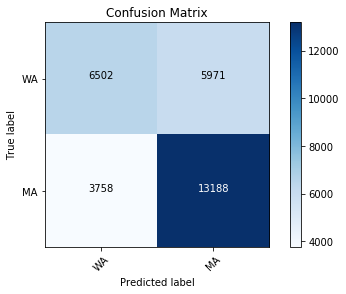

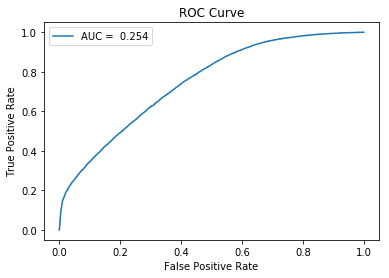

F1-score = 0.731, Accuracy = 0.669, Precision = 0.688, Recall = 0.778


In [41]:
# print(X.shape, y.shape)
logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
y_pred_prob = logistic.predict_proba(X_test)
show_stats(y_test, y_pred, y_pred_prob)

b) Afterwards, we applied a random forest classifier.

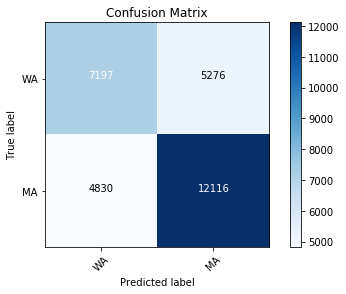

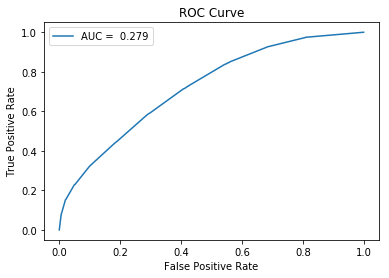

F1-score = 0.706, Accuracy = 0.656, Precision = 0.697, Recall = 0.715


In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
show_stats(y_test, y_pred, y_pred_prob)

c) Finally, we employed a multinomial Naive Bayes classifier. This type of model is suitable for classification with discrete features and in practice, fractional counts such as tf-idf representations also work, which is the case in our machine learning problem.


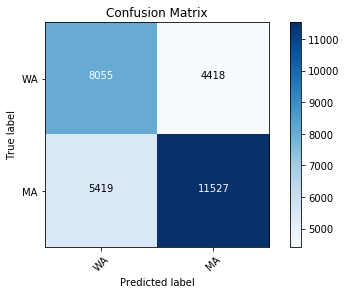

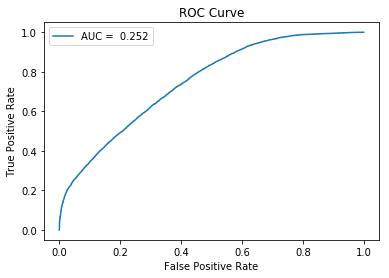

F1-score = 0.701, Accuracy = 0.666, Precision = 0.723, Recall = 0.680
CPU times: user 334 ms, sys: 70.3 ms, total: 404 ms
Wall time: 487 ms


In [44]:
%%time
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
show_stats(y_test, y_pred, y_pred_prob)

Overall, comparing these three models' results, one can claim that...

# Prediction of Game Results based on Tweet Sentiment

To build upon the previous section's exploration with using tweet semantics for prediction, we will describe a model that can predict the winner (and loser) of the game based on the current tweet sentiment for both participating teams.
Given that team A and team B are paritipating in the superbowl, the features we used are:
* Total number of positive tweets for #go{team A}
* Total number of negative tweets for #go{team A}
* Total number of retweets for #go{team A}
* Total number of positive tweets for #go{team B}
* Total number of negative tweets for #go{team B}
* Total number of retweets for #go{team B}

For our given dataset of superbowl 15, we collect the tweet statistics from #gopatriots and #gohawks. To determine whether a given tweet is positive, we use the sentiment analyzer API provided by Textblob (https://pypi.python.org/pypi/textblob)

We employed a logistic regression model to predict the outcome of the game. Unfortunately, since our given dataset is regarding only one superbowl game, we could only create one training example, which of course is not sufficient to generate a robust model. If we had sufficient time, we would first collect the same kind of tweet statistics for all the past superbowl games (starting from superbowl 2007 since Twitter was founded in early 2006). In addition, since this gives us only ten more examples, we would collect tweet datasets for at least a couple hundred NFL football games to finally generate a decently sized training set.

In [ ]:
data_dir = '/Volumes/TOCOMBINE/tweet_data' # MAKE SURE TO CHANGE THIS TO WHERE EVER YOUR DATA IS. 
# The total data size is ~14gb which is too large to be committed into github

# Puts data into dict
hashtags = ['gopatriots']
data = {}
for hashtag in hashtags:
    file_name = data_dir + '/tweets_#' + hashtag + '.txt' 
    with open(file_name, 'r') as f:
        tweets = []
        for i, l in enumerate(f):
            tweet = json.loads(l)
            tweets.append(tweet)
        data[hashtag] = tweets

In [ ]:
from textblob import TextBlob
import regex as re

def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

row = []
for hashtag in hashtags:
    positives, negatives, retweets = 0, 0, 0
    for tweet in data[hashtag]:
        sentiment = get_tweet_sentiment(tweet['tweet']['text'])
        if sentiment is 'positive':
            positives += 1
        elif sentiment is 'negative':
            negatives += 1
        retweets += tweet['metrics']['citations']['total']
    row.append(positives)
    row.append(negatives)
    row.append(retweets)
X = np.array(row)
y = np.array([1,0]) # Patriots won, Seahwaks lost

In [ ]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, y)
y_pred = logistic.predict(X)
y_pred_prob = logistic.predict_proba(X)
show_stats(y, y_pred, y_pred_prob)

The performance of the logistic regression model is summarized above. This, of course, is meaningless to analyze as we only utilized one trainig example. However, with more data, we are certain that we can create a generalizable predictor of superbowl champions based on both teams' fans' tweet sentiment. Our intuition is that the winning team will gather more both positive and negative tweets than those of the losing team, as the winning fan is most likely to tweet a positive tweet about his or her winning team, and the losing fan is most likely to tweet a negative tweet about the opposing team's undeserved victory.